# FaceNet的实现 version2

## 参考 https://github.com/tamerthamoqa/facenet-pytorch-vggface2
## 以及brook的代码，尝试将两者结合

## 修改部分：

1. 修复了变成ipynb后的bug

2. 减少了无用的plot，并改善plot的画质

In [1]:
#基本的引入，按字母表排序
import argparse
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
import random
#from random import shuffle
import sys
sys.path.append(r'dataloaders')
#torch部分的import
import torch
from torch.autograd import Function
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
from tqdm import tqdm
from PIL import Image
import pandas as pd

#从py文件中引入functions
from dataloaders.LFWDataset import LFWDataset
from dataloaders.triplet_loss_dataloader import TripletFaceDataset
from validate_on_LFW import evaluate_lfw
from plot import plot_roc_lfw, plot_accuracy_lfw, plot_triplet_losses


# 设置随机数种子

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

# 设立args

In [3]:
def config():
    parser = argparse.ArgumentParser(description="Training a FaceNet facial recognition model using Triplet Loss.")
    # Dataset
    parser.add_argument('--dataroot', '-d', type=str, default="Cropped_images",
                        help="(REQUIRED) Absolute path to the dataset folder"
                        )
    # LFW
    parser.add_argument('--lfw', type=str, default="Cropped_images",
                        help="(REQUIRED) Absolute path to the labeled faces in the wild dataset folder"
                        )
    parser.add_argument('--dataset_csv', type=str, default='datasets/lfw_train.csv',
                        help="Path to the csv file containing the image paths of the training dataset."
                        )
    parser.add_argument('--lfw_batch_size', default=64, type=int,
                        help="Batch size for LFW dataset (default: 64)"
                        )
    parser.add_argument('--lfw_validation_epoch_interval', default=1, type=int,
                        help="Perform LFW validation every n epoch interval (default: every 1 epoch)"
                        )
    # Training settings
    parser.add_argument('--model', type=str, default="resnet18", choices=["resnet18","resnet34"],
        help="The required model architecture for training: (“resnet18”,'resnet34'), (default: 'resnet34')"
                        )
    parser.add_argument('--epochs', default=50, type=int,
                        help="Required training epochs (default: 30)"
                        )
    parser.add_argument('--training_triplets_path', default=None, type=str,
        help="Path to training triplets numpy file in 'datasets/' folder to skip training triplet generation step."
                        )
    parser.add_argument('--num_triplets_train', default=10000, type=int,
                        help="Number of triplets for training (default: 1100000)"
                        )
    parser.add_argument('--resume_path', default='',  type=str,
        help='path to latest model checkpoint: (Model_training_checkpoints/model_resnet34_epoch_0.pt file) (default: None)'
                        )
    parser.add_argument('--batch_size', default=16, type=int,
                        help="Batch size (default: 32)"
                        )
    parser.add_argument('--num_workers', default=0, type=int,
                        help="Number of workers for data loaders (default: 0)"
                        #不为零就会报错，原因是shared memory不够，而sharedmemory提高需要sudo权限。据我搜集的信息，目前没有其他解决办法
                        )
    parser.add_argument('--embedding_dim', default=256, type=int,
                        help="Dimension of the embedding vector (default: 128)"
                        )
    parser.add_argument('--pretrained', default=True, type=bool,
                        help="Download a model pretrained on the ImageNet dataset (Default: False)"
                        )
    parser.add_argument('--optimizer', type=str, default="adam", choices=["sgd", "adagrad", "rmsprop", "adam"],
        help="Required optimizer for training the model: ('sgd','adagrad','rmsprop','adam'), (default: 'adam')"
                        )
    parser.add_argument('--lr', default=0.001, type=float,
                        help="Learning rate for the optimizer (default: 0.1)"
                        )
    parser.add_argument('--margin', default=0.5, type=float,
                        help='margin for triplet loss (default: 0.5)'
                        )
    args = parser.parse_args(args=[])
    return args

args=config()

#  Earlystopping

In [4]:
#改编版！新增monitor(mIoU)
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, monitor="val_acc", patience=7, verbose=False, delta=0):
        """
        Args:
            monitor (string): 可以选 "val_acc"or "val_loss"or"val_mIoU"
                            
                            Default: "val_acc"
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.monitor=monitor
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc_max = 0
        self.val_mIoU_max = 0
        self.delta = delta
    
    def __call__(self, val, model):
        if self.monitor=='val_loss':
            val_loss=val
            score = -val_loss

            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model)
                self.counter = 0
        elif self.monitor=='val_acc':
            #这里的val是0-100之间的数。
            val_acc=val
            score = val_acc
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_acc, model)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_acc, model)
                self.counter = 0   
        elif self.monitor=='val_mIoU':
            #这里的val是0-100之间的数。
            val_mIoU=val
            score = val_mIoU
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_mIoU, model)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_mIoU, model)
                self.counter = 0 
    def save_checkpoint(self, val, model):
        '''Saves model when validation loss decrease.'''
        '''Saves model when validation accuracy increase.'''
        if self.monitor=='val_loss':
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val:.6f}).  Saving model ...')           
            self.val_loss_min = val
        if self.monitor=='val_acc':
            if self.verbose:
                print(f'Validation accuracy increased ({self.val_acc_max:.6f}% --> {val:.6f}%).  Saving model ...')
            self.val_acc_max = val
        if self.monitor=='val_mIoU':
            if self.verbose:
                print(f'Validation mIoU increased ({self.val_mIoU_max:.6f} --> {val:.6f}).  Saving model ...')
            self.val_mIoU_max = val
        torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数

# 一些辅助functions

In [5]:
def set_model_architecture(model_architecture, pretrained, embedding_dimension):
    if model_architecture == "resnet18":
        model = Resnet18Triplet(
            embedding_dimension=embedding_dimension,
            pretrained=pretrained
        )
    elif model_architecture == "resnet34":
        model = Resnet34Triplet(
            embedding_dimension=embedding_dimension,
            pretrained=pretrained
        )
    print("Using {} model architecture.".format(model_architecture))

    return model

In [6]:
def set_model_gpu_mode(model):
    flag_train_gpu = torch.cuda.is_available()
    flag_train_multi_gpu = False

    if flag_train_gpu and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        model.cuda()
        flag_train_multi_gpu = True
        print('Using multi-gpu training.')

    elif flag_train_gpu and torch.cuda.device_count() == 1:
        model.cuda()
        print('Using single-gpu training.')
    return model, flag_train_multi_gpu

In [7]:
def set_optimizer(optimizer, model, learning_rate):
    if optimizer == "sgd":
        optimizer_model = torch.optim.SGD(model.parameters(), lr=learning_rate)

    elif optimizer == "adagrad":
        optimizer_model = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

    elif optimizer == "rmsprop":
        optimizer_model = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    elif optimizer == "adam":
        optimizer_model = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

    return optimizer_model


# 设立dataset

## 参考 龚绪晨brooke 的写法

In [8]:
class IFWdataset(Dataset):
    
    def __init__(self, phase,dataroot):
        
        self.endidx = {'train': 4037, 'test': 1710}.get(phase)
        self.root = dataroot
        self.all_frame = pd.read_csv('datasets/people' + phase + '.csv')
        self.anc_frame = self.all_frame.loc[self.all_frame.images > 1]
        
        
    def __getitem__(self, index):
        
        anc_name, anc_img_num = self.anc_frame.iloc[index]
        anc_id, pos_id = random.sample(range(1, anc_img_num+1), 2)
        
        neg_name = anc_name
        while neg_name == anc_name:
            n = random.randint(0,self.endidx)
            neg_name, neg_img_num = self.all_frame.iloc[n]
        neg_id = random.randint(1,neg_img_num)
        
        
        anc = anc_name + '_' + ('000'+ str(anc_id))[-4:] + '.jpg'
        anc = Image.open(os.path.join(self.root,anc_name,anc))
        anc = tf.resize(anc, (160,160))
        anc = transforms.RandomHorizontalFlip(p=0.5)(anc)
        anc = tf.to_tensor(anc)
        anc = tf.normalize(anc, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        pos = anc_name + '_' + ('000'+ str(pos_id))[-4:] + '.jpg'
        pos = Image.open(os.path.join(self.root,anc_name,pos))
        pos = tf.resize(pos, (160,160))
        pos = transforms.RandomHorizontalFlip(p=0.5)(pos)
        pos = tf.to_tensor(pos)
        pos = tf.normalize(pos, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        neg = neg_name + '_' + ('000'+ str(neg_id))[-4:] + '.jpg'
        neg = Image.open(os.path.join(self.root,neg_name,neg))
        neg = tf.resize(neg,(160,160))
        neg = transforms.RandomHorizontalFlip(p=0.5)(neg)
        neg = tf.to_tensor(neg)
        neg = tf.normalize(neg, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return anc, pos, neg
   

    def __len__(self):
        return len(self.anc_frame) # train 1184, test 496

# Model-Resnet18

In [9]:
class Resnet18Triplet(nn.Module):
    """Constructs a ResNet-18 model for FaceNet training using triplet loss.
    Args:
        embedding_dimension (int): Required dimension of the resulting embedding layer that is outputted by the model.
                                   using triplet loss. Defaults to 128.
        pretrained (bool): If True, returns a model pre-trained on the ImageNet dataset from a PyTorch repository.
                           Defaults to False.
    """

    def __init__(self, embedding_dimension=128, pretrained=False):
        super(Resnet18Triplet, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=pretrained)
        input_features_fc_layer = self.model.fc.in_features
        # Output embedding
        self.model.fc = nn.Linear(input_features_fc_layer, embedding_dimension)

    def l2_norm(self, input):
        """Perform l2 normalization operation on an input vector.
        code copied from liorshk's repository: https://github.com/liorshk/facenet_pytorch/blob/master/model.py
        """
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)

        return output

    def forward(self, images):
        """Forward pass to output the embedding vector (feature vector) after l2-normalization and multiplication
        by scalar (alpha)."""
        embedding = self.model(images)
        embedding = self.l2_norm(embedding)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        #   Equation 9: number of classes in VGGFace2 dataset = 9131
        #   lower bound on alpha = 5, multiply alpha by 2; alpha = 10
        alpha = 10
        embedding = embedding * alpha

        return embedding

# Model-Resnet34

In [10]:
class Resnet34Triplet(nn.Module):
    """Constructs a ResNet-34 model for FaceNet training using triplet loss.
    Args:
        embedding_dimension (int): Required dimension of the resulting embedding layer that is outputted by the model.
                                   using triplet loss. Defaults to 128.
        pretrained (bool): If True, returns a model pre-trained on the ImageNet dataset from a PyTorch repository.
                           Defaults to False.
    """

    def __init__(self, embedding_dimension=128, pretrained=False):
        super(Resnet34Triplet, self).__init__()
        #从pytorch官方下载resnet34
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=pretrained)
        input_features_fc_layer = self.model.fc.in_features
        # Output embedding
        self.model.fc = nn.Linear(input_features_fc_layer, embedding_dimension)

    def l2_norm(self, input):
        """Perform l2 normalization operation on an input vector.
        code copied from liorshk's repository: https://github.com/liorshk/facenet_pytorch/blob/master/model.py
        """
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)

        return output

    def forward(self, images):
        """Forward pass to output the embedding vector (feature vector) after l2-normalization and multiplication
        by scalar (alpha)."""
        embedding = self.model(images)
        embedding = self.l2_norm(embedding)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        #   Equation 9: number of classes in VGGFace2 dataset = 9131
        #   lower bound on alpha = 5, multiply alpha by 2; alpha = 10
        alpha = 10
        embedding = embedding * alpha

        return embedding

### 可以利用已经训练好的参数

In [11]:
# checkpoint = torch.load('model_resnet34_triplet.pt')
# model = Resnet34Triplet(embedding_dimension=checkpoint['embedding_dimension'])
# model.load_state_dict(checkpoint['model_state_dict'])
# best_distance_threshold = checkpoint['best_distance_threshold']

# TripletLoss

## 这里只是写出了，后面训练的时候其实使用的是pytorch官方提供的tripletLoss

In [12]:
class TripletLoss(Function):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)

    def forward(self, anchor, positive, negative):
        pos_dist = self.pdist.forward(anchor, positive)
        neg_dist = self.pdist.forward(anchor, negative)

        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        loss = torch.mean(hinge_dist)

        return loss

# Train

In [22]:
def train_triplet(epochs, train_dataloader, eval_dataloader, model,optimizer_model,margin):
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the training accuracy per epoch as the model trains
    train_accuracies = [] 
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the validation accuracy per epoch as the model trains
    valid_accuracies = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping("val_acc",patience=30, verbose=True,delta=0.001)
    for epoch in range(epochs):
        num_valid_training_triplets = 0
        l2_distance = PairwiseDistance(2).cuda()
        ###################
        # train the model #
        ###################
        model.train()
        # to track the training loss as the model trains
        train_losses = []
        labels, distances = [], []
        for (anc_img,pos_img,neg_img) in tqdm(train_dataloader):
            anc_img = anc_img.cuda()
            pos_img = pos_img.cuda()
            neg_img = neg_img.cuda()
            # Forward pass - compute embeddings
            anc_embedding, pos_embedding, neg_embedding = model(anc_img), model(pos_img), model(neg_img)
            # Forward pass - choose hard negatives only for training
            pos_dist = l2_distance.forward(anc_embedding, pos_embedding)
            neg_dist = l2_distance.forward(anc_embedding, neg_embedding)
            all = (neg_dist - pos_dist < margin).cpu().numpy().flatten()
            hard_triplets = np.where(all == 1)
            if len(hard_triplets[0]) == 0:
                continue
            anc_hard_embedding = anc_embedding[hard_triplets].cuda()
            pos_hard_embedding = pos_embedding[hard_triplets].cuda()
            neg_hard_embedding = neg_embedding[hard_triplets].cuda()
            # Calculate triplet loss
            triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)
            output= triplet_loss(
                anchor=anc_hard_embedding,
                positive=pos_hard_embedding,
                negative=neg_hard_embedding
            ).cuda()
            # Calculating loss
            train_losses.append(output.item())
            num_valid_training_triplets += len(anc_hard_embedding)
            # Backward pass
            optimizer_model.zero_grad()
            output.backward()
            optimizer_model.step()
            #检测accuracy
            distances.append(neg_dist.data.cpu().numpy())
            labels.append(np.zeros(neg_dist.size(0)))
            distances.append(pos_dist.data.cpu().numpy())
            labels.append(np.ones(pos_dist.size(0)))
        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for distance in distances for subdist in distance])

        true_positive_rate, false_positive_rate, precision, recall, train_accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances,
            labels=labels)
        # Model only trains on hard negative triplets
        avg_triplet_loss = 0 if (num_valid_training_triplets == 0) else np.mean(train_losses)
        avg_train_losses.append(avg_triplet_loss)
        train_accuracies.append(np.mean(train_accuracy))
        # Print training statistics and add to log
        print('Epoch {}:\tAverage Training Triplet Loss: {:.4f}\t Training Accuracy: {:.4f}+-{:.4f}\tNumber of valid training triplets in epoch: {} '.format(
                epoch + 1,
                avg_triplet_loss,
                np.mean(train_accuracy),
                np.std( train_accuracy),
                num_valid_training_triplets
            )
        ) 
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        # to track the validation loss as the model trains
        valid_losses = []
        labels, distances = [], []
        for (anc_img,pos_img,neg_img) in tqdm(eval_dataloader):
            anc_img = anc_img.cuda()
            pos_img = pos_img.cuda()
            neg_img = neg_img.cuda()
            # Forward pass - compute embeddings
            anc_embedding, pos_embedding, neg_embedding = model(anc_img), model(pos_img), model(neg_img)
            # Forward pass - choose hard negatives only for training
            pos_dist = l2_distance.forward(anc_embedding, pos_embedding)
            neg_dist = l2_distance.forward(anc_embedding, neg_embedding)
            # Calculate triplet loss
            triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)
            output= triplet_loss(
                anchor=anc_embedding,
                positive=pos_embedding,
                negative=neg_embedding
            ).cuda()
            # Calculating loss
            valid_losses.append(output.item())
            #检测accuracy
            distances.append(neg_dist.data.cpu().numpy())
            labels.append(np.zeros(neg_dist.size(0)))
            distances.append(pos_dist.data.cpu().numpy())
            labels.append(np.ones(pos_dist.size(0)))
        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for distance in distances for subdist in distance])

        true_positive_rate, false_positive_rate, precision, recall, valid_accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances,
            labels=labels)
        
        print('Epoch {}:\tAverage Valid Triplet Loss: {:.4f}\t Valid Accuracy: {:.4f}+-{:.4f}'.format(
                epoch + 1,
                np.mean(valid_losses),
                np.mean(valid_accuracy),
                np.std( valid_accuracy)
            )
        ) 
        avg_valid_losses.append(np.mean(valid_losses))
        valid_accuracies.append(np.mean(valid_accuracy))
        
        
        # early_stopping needs the validation acc to check if it has incresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(np.mean(valid_accuracy), model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('checkpoint.pt'))
    print("Done!")
    return model, avg_train_losses, avg_valid_losses,train_accuracies,valid_accuracies

# 在LFW数据集上validate测试

In [23]:
def validate_lfw(model, lfw_dataloader, model_architecture, epoch, epochs):
    model.eval()
    with torch.no_grad():
        l2_distance = PairwiseDistance(2).cuda()
        distances, labels = [], []

        print("Validating on LFW! ...")

        for batch_index, (data_a, data_b, label) in tqdm(lfw_dataloader):
            data_a, data_b, label = data_a.cuda(), data_b.cuda(), label.cuda()

            output_a, output_b = model(data_a), model(data_b)
            distance = l2_distance.forward(output_a, output_b)  # Euclidean distance

            distances.append(distance.cpu().detach().numpy())
            labels.append(label.cpu().detach().numpy())

        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for distance in distances for subdist in distance])

        true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances,
            labels=labels
        )
        # Print statistics and add to log
        print("Accuracy on LFW: {:.4f}+-{:.4f}\tPrecision {:.4f}+-{:.4f}\tRecall {:.4f}+-{:.4f}\t"
              "ROC Area Under Curve: {:.4f}\tBest distance threshold: {:.2f}+-{:.2f}\t"
              "TAR: {:.4f}+-{:.4f} @ FAR: {:.4f}".format(
                np.mean(accuracy),
                np.std(accuracy),
                np.mean(precision),
                np.std(precision),
                np.mean(recall),
                np.std(recall),
                roc_auc,
                np.mean(best_distances),
                np.std(best_distances),
                np.mean(tar),
                np.std(tar),
                np.mean(far)
            )
        )
        with open('logs/lfw_{}_log_triplet.txt'.format(model_architecture), 'a') as f:
            val_list = [
                epoch + 1,
                np.mean(accuracy),
                np.std(accuracy),
                np.mean(precision),
                np.std(precision),
                np.mean(recall),
                np.std(recall),
                roc_auc,
                np.mean(best_distances),
                np.std(best_distances),
                np.mean(tar)
            ]
            log = '\t'.join(str(value) for value in val_list)
            f.writelines(log + '\n')
    try:
        # Plot ROC curve
        plot_roc_lfw(
            false_positive_rate=false_positive_rate,
            true_positive_rate=true_positive_rate,
            figure_name="plots/roc_plots/roc_{}_epoch_{}_triplet.png".format(model_architecture, epoch + 1)
        )
    except Exception as e:
        print(e)
        
    return best_distances

# 设立dataloaders

In [24]:
dataroot = args.dataroot
lfw_dataroot = args.lfw
dataset_csv = args.dataset_csv
lfw_batch_size = args.lfw_batch_size
num_triplets_train = args.num_triplets_train
model_architecture = args.model
epochs = args.epochs
embedding_dimension = args.embedding_dim
pretrained = args.pretrained
optimizer = args.optimizer
learning_rate = args.lr
margin = args.margin
batch_size = args.batch_size
num_workers = args.num_workers

#Set dataloaders
trainSet = IFWdataset('train',dataroot)
train_dataloader = DataLoader(
    trainSet, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=False)

evalSet = IFWdataset('test',dataroot)
eval_dataloader = DataLoader(
    evalSet, 
    batch_size=lfw_batch_size,
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=False)


# lfw_valid_dataset=LFWDataset(
#         dir=lfw_dataroot,
#         pairs_path='datasets/LFW_pairs.txt',
#         #pairs_path='txt/pairsDevTest.txt',
#         transform=lfw_transforms
#     )
# lfw_dataloader = DataLoader(
#     lfw_valid_dataset,
#     batch_size=lfw_batch_size,
#     num_workers=num_workers,
#     shuffle=False
# )

# 初始化model，设定 optimizer，learning_rate

In [25]:
# Instantiate model
model = set_model_architecture(
    model_architecture=model_architecture,
    pretrained=pretrained,
    embedding_dimension=embedding_dimension
)

# # 利用pretrain的model

# checkpoint = torch.load('model_resnet34_triplet.pt')
# model = Resnet34Triplet(embedding_dimension=checkpoint['embedding_dimension'])
# model.load_state_dict(checkpoint['model_state_dict'])
# best_distance_threshold = checkpoint['best_distance_threshold']



# Load model to GPU or multiple GPUs if available
model, flag_train_multi_gpu = set_model_gpu_mode(model)

# Set optimizer
optimizer_model = set_optimizer(
    optimizer=optimizer,
    model=model,
    learning_rate=learning_rate
)


Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.6.0


Using resnet18 model architecture.
Using single-gpu training.


# 开始训练

In [26]:
# Start training model using Triplet Loss
model, train_loss, valid_loss, train_acc, valid_acc =train_triplet(
    epochs=epochs,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    model=model,
    optimizer_model=optimizer_model,
    margin=margin
)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:	Average Training Triplet Loss: 1.0894	 Training Accuracy: 0.5503+-0.0364	Number of valid training triplets in epoch: 616 


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 1:	Average Valid Triplet Loss: 0.4259	 Valid Accuracy: 0.5907+-0.0294
Validation accuracy increased (0.000000% --> 0.590717%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2:	Average Training Triplet Loss: 0.5974	 Training Accuracy: 0.6221+-0.0231	Number of valid training triplets in epoch: 741 


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Epoch 2:	Average Valid Triplet Loss: 0.3399	 Valid Accuracy: 0.6612+-0.0395
Validation accuracy increased (0.590717% --> 0.661162%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3:	Average Training Triplet Loss: 0.5847	 Training Accuracy: 0.6546+-0.0377	Number of valid training triplets in epoch: 662 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3:	Average Valid Triplet Loss: 0.3814	 Valid Accuracy: 0.5948+-0.0361
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4:	Average Training Triplet Loss: 0.5574	 Training Accuracy: 0.6588+-0.0164	Number of valid training triplets in epoch: 628 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4:	Average Valid Triplet Loss: 0.3929	 Valid Accuracy: 0.6391+-0.0492
EarlyStopping counter: 2 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5:	Average Training Triplet Loss: 0.5887	 Training Accuracy: 0.6664+-0.0294	Number of valid training triplets in epoch: 641 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5:	Average Valid Triplet Loss: 0.3539	 Valid Accuracy: 0.6461+-0.0528
EarlyStopping counter: 3 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6:	Average Training Triplet Loss: 0.5394	 Training Accuracy: 0.6807+-0.0303	Number of valid training triplets in epoch: 600 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6:	Average Valid Triplet Loss: 0.3174	 Valid Accuracy: 0.6180+-0.0205
EarlyStopping counter: 4 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7:	Average Training Triplet Loss: 0.5496	 Training Accuracy: 0.7086+-0.0332	Number of valid training triplets in epoch: 580 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7:	Average Valid Triplet Loss: 0.3687	 Valid Accuracy: 0.6038+-0.0475
EarlyStopping counter: 5 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8:	Average Training Triplet Loss: 0.5216	 Training Accuracy: 0.7044+-0.0241	Number of valid training triplets in epoch: 603 


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 8:	Average Valid Triplet Loss: 0.2842	 Valid Accuracy: 0.6976+-0.0481
Validation accuracy increased (0.661162% --> 0.697626%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9:	Average Training Triplet Loss: 0.5437	 Training Accuracy: 0.7246+-0.0306	Number of valid training triplets in epoch: 532 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 9:	Average Valid Triplet Loss: 0.2961	 Valid Accuracy: 0.6815+-0.0339
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10:	Average Training Triplet Loss: 0.5393	 Training Accuracy: 0.7124+-0.0144	Number of valid training triplets in epoch: 511 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 10:	Average Valid Triplet Loss: 0.2781	 Valid Accuracy: 0.6945+-0.0466
EarlyStopping counter: 2 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11:	Average Training Triplet Loss: 0.5091	 Training Accuracy: 0.7242+-0.0392	Number of valid training triplets in epoch: 572 


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 11:	Average Valid Triplet Loss: 0.2372	 Valid Accuracy: 0.7329+-0.0358
Validation accuracy increased (0.697626% --> 0.732909%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12:	Average Training Triplet Loss: 0.5240	 Training Accuracy: 0.7395+-0.0256	Number of valid training triplets in epoch: 498 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 12:	Average Valid Triplet Loss: 0.2896	 Valid Accuracy: 0.6755+-0.0455
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13:	Average Training Triplet Loss: 0.5163	 Training Accuracy: 0.7436+-0.0267	Number of valid training triplets in epoch: 475 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 13:	Average Valid Triplet Loss: 0.2482	 Valid Accuracy: 0.7198+-0.0480
EarlyStopping counter: 2 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14:	Average Training Triplet Loss: 0.5275	 Training Accuracy: 0.7395+-0.0219	Number of valid training triplets in epoch: 499 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 14:	Average Valid Triplet Loss: 0.2390	 Valid Accuracy: 0.7108+-0.0369
EarlyStopping counter: 3 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15:	Average Training Triplet Loss: 0.5311	 Training Accuracy: 0.7357+-0.0299	Number of valid training triplets in epoch: 492 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 15:	Average Valid Triplet Loss: 0.2538	 Valid Accuracy: 0.7136+-0.0471
EarlyStopping counter: 4 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16:	Average Training Triplet Loss: 0.5290	 Training Accuracy: 0.7403+-0.0363	Number of valid training triplets in epoch: 465 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 16:	Average Valid Triplet Loss: 0.2559	 Valid Accuracy: 0.7126+-0.0380
EarlyStopping counter: 5 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17:	Average Training Triplet Loss: 0.5272	 Training Accuracy: 0.7325+-0.0383	Number of valid training triplets in epoch: 496 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 17:	Average Valid Triplet Loss: 0.2350	 Valid Accuracy: 0.7118+-0.0455
EarlyStopping counter: 6 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18:	Average Training Triplet Loss: 0.5248	 Training Accuracy: 0.7665+-0.0315	Number of valid training triplets in epoch: 428 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 18:	Average Valid Triplet Loss: 0.2799	 Valid Accuracy: 0.7058+-0.0475
EarlyStopping counter: 7 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19:	Average Training Triplet Loss: 0.5387	 Training Accuracy: 0.7471+-0.0256	Number of valid training triplets in epoch: 448 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 19:	Average Valid Triplet Loss: 0.2702	 Valid Accuracy: 0.6905+-0.0451
EarlyStopping counter: 8 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20:	Average Training Triplet Loss: 0.5116	 Training Accuracy: 0.7605+-0.0306	Number of valid training triplets in epoch: 420 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 20:	Average Valid Triplet Loss: 0.2650	 Valid Accuracy: 0.6925+-0.0380
EarlyStopping counter: 9 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21:	Average Training Triplet Loss: 0.4924	 Training Accuracy: 0.7525+-0.0325	Number of valid training triplets in epoch: 472 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 21:	Average Valid Triplet Loss: 0.2420	 Valid Accuracy: 0.7168+-0.0391
EarlyStopping counter: 10 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22:	Average Training Triplet Loss: 0.5353	 Training Accuracy: 0.7614+-0.0264	Number of valid training triplets in epoch: 420 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 22:	Average Valid Triplet Loss: 0.2476	 Valid Accuracy: 0.7207+-0.0645
EarlyStopping counter: 11 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23:	Average Training Triplet Loss: 0.5161	 Training Accuracy: 0.7707+-0.0201	Number of valid training triplets in epoch: 424 


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 23:	Average Valid Triplet Loss: 0.1842	 Valid Accuracy: 0.7581+-0.0526
Validation accuracy increased (0.732909% --> 0.758071%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24:	Average Training Triplet Loss: 0.5364	 Training Accuracy: 0.7601+-0.0122	Number of valid training triplets in epoch: 432 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 24:	Average Valid Triplet Loss: 0.2147	 Valid Accuracy: 0.7329+-0.0511
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25:	Average Training Triplet Loss: 0.5280	 Training Accuracy: 0.7597+-0.0356	Number of valid training triplets in epoch: 456 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 25:	Average Valid Triplet Loss: 0.2332	 Valid Accuracy: 0.7420+-0.0463
EarlyStopping counter: 2 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26:	Average Training Triplet Loss: 0.4978	 Training Accuracy: 0.7741+-0.0277	Number of valid training triplets in epoch: 417 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 26:	Average Valid Triplet Loss: 0.1950	 Valid Accuracy: 0.7541+-0.0417
EarlyStopping counter: 3 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27:	Average Training Triplet Loss: 0.5150	 Training Accuracy: 0.7705+-0.0189	Number of valid training triplets in epoch: 412 


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Epoch 27:	Average Valid Triplet Loss: 0.1970	 Valid Accuracy: 0.7622+-0.0343
Validation accuracy increased (0.758071% --> 0.762152%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28:	Average Training Triplet Loss: 0.4897	 Training Accuracy: 0.7854+-0.0277	Number of valid training triplets in epoch: 366 


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 28:	Average Valid Triplet Loss: 0.1929	 Valid Accuracy: 0.7641+-0.0268
Validation accuracy increased (0.762152% --> 0.764101%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29:	Average Training Triplet Loss: 0.5270	 Training Accuracy: 0.7909+-0.0217	Number of valid training triplets in epoch: 336 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 29:	Average Valid Triplet Loss: 0.2021	 Valid Accuracy: 0.7611+-0.0505
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30:	Average Training Triplet Loss: 0.5304	 Training Accuracy: 0.7884+-0.0217	Number of valid training triplets in epoch: 353 


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 30:	Average Valid Triplet Loss: 0.1801	 Valid Accuracy: 0.7763+-0.0534
Validation accuracy increased (0.764101% --> 0.776253%).  Saving model ...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31:	Average Training Triplet Loss: 0.5142	 Training Accuracy: 0.7859+-0.0240	Number of valid training triplets in epoch: 355 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 31:	Average Valid Triplet Loss: 0.1970	 Valid Accuracy: 0.7612+-0.0454
EarlyStopping counter: 1 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32:	Average Training Triplet Loss: 0.5305	 Training Accuracy: 0.7775+-0.0358	Number of valid training triplets in epoch: 392 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 32:	Average Valid Triplet Loss: 0.1760	 Valid Accuracy: 0.7581+-0.0444
EarlyStopping counter: 2 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33:	Average Training Triplet Loss: 0.5020	 Training Accuracy: 0.7981+-0.0254	Number of valid training triplets in epoch: 365 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 33:	Average Valid Triplet Loss: 0.2345	 Valid Accuracy: 0.7692+-0.0556
EarlyStopping counter: 3 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34:	Average Training Triplet Loss: 0.4992	 Training Accuracy: 0.7956+-0.0225	Number of valid training triplets in epoch: 355 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 34:	Average Valid Triplet Loss: 0.1922	 Valid Accuracy: 0.7731+-0.0410
EarlyStopping counter: 4 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35:	Average Training Triplet Loss: 0.5145	 Training Accuracy: 0.8053+-0.0323	Number of valid training triplets in epoch: 329 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 35:	Average Valid Triplet Loss: 0.2151	 Valid Accuracy: 0.7379+-0.0340
EarlyStopping counter: 5 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36:	Average Training Triplet Loss: 0.5719	 Training Accuracy: 0.7766+-0.0229	Number of valid training triplets in epoch: 364 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 36:	Average Valid Triplet Loss: 0.1822	 Valid Accuracy: 0.7701+-0.0347
EarlyStopping counter: 6 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37:	Average Training Triplet Loss: 0.4734	 Training Accuracy: 0.7884+-0.0215	Number of valid training triplets in epoch: 340 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 37:	Average Valid Triplet Loss: 0.1693	 Valid Accuracy: 0.7721+-0.0494
EarlyStopping counter: 7 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38:	Average Training Triplet Loss: 0.5177	 Training Accuracy: 0.8212+-0.0265	Number of valid training triplets in epoch: 288 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 38:	Average Valid Triplet Loss: 0.2178	 Valid Accuracy: 0.7521+-0.0449
EarlyStopping counter: 8 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39:	Average Training Triplet Loss: 0.5098	 Training Accuracy: 0.8032+-0.0264	Number of valid training triplets in epoch: 313 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 39:	Average Valid Triplet Loss: 0.2041	 Valid Accuracy: 0.7682+-0.0293
EarlyStopping counter: 9 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40:	Average Training Triplet Loss: 0.5556	 Training Accuracy: 0.7952+-0.0279	Number of valid training triplets in epoch: 335 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 40:	Average Valid Triplet Loss: 0.1867	 Valid Accuracy: 0.7602+-0.0482
EarlyStopping counter: 10 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41:	Average Training Triplet Loss: 0.4865	 Training Accuracy: 0.7979+-0.0247	Number of valid training triplets in epoch: 342 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 41:	Average Valid Triplet Loss: 0.2227	 Valid Accuracy: 0.7269+-0.0373
EarlyStopping counter: 11 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42:	Average Training Triplet Loss: 0.5457	 Training Accuracy: 0.7880+-0.0368	Number of valid training triplets in epoch: 372 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 42:	Average Valid Triplet Loss: 0.1705	 Valid Accuracy: 0.7641+-0.0324
EarlyStopping counter: 12 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43:	Average Training Triplet Loss: 0.4763	 Training Accuracy: 0.8099+-0.0231	Number of valid training triplets in epoch: 319 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 43:	Average Valid Triplet Loss: 0.1777	 Valid Accuracy: 0.7772+-0.0392
EarlyStopping counter: 13 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44:	Average Training Triplet Loss: 0.5359	 Training Accuracy: 0.8172+-0.0329	Number of valid training triplets in epoch: 306 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 44:	Average Valid Triplet Loss: 0.2223	 Valid Accuracy: 0.7339+-0.0313
EarlyStopping counter: 14 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45:	Average Training Triplet Loss: 0.4888	 Training Accuracy: 0.8083+-0.0174	Number of valid training triplets in epoch: 326 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 45:	Average Valid Triplet Loss: 0.1670	 Valid Accuracy: 0.7723+-0.0460
EarlyStopping counter: 15 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46:	Average Training Triplet Loss: 0.4942	 Training Accuracy: 0.8154+-0.0272	Number of valid training triplets in epoch: 304 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 46:	Average Valid Triplet Loss: 0.1688	 Valid Accuracy: 0.7581+-0.0561
EarlyStopping counter: 16 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47:	Average Training Triplet Loss: 0.4858	 Training Accuracy: 0.8065+-0.0264	Number of valid training triplets in epoch: 295 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 47:	Average Valid Triplet Loss: 0.2157	 Valid Accuracy: 0.7398+-0.0593
EarlyStopping counter: 17 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48:	Average Training Triplet Loss: 0.5386	 Training Accuracy: 0.7956+-0.0195	Number of valid training triplets in epoch: 327 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 48:	Average Valid Triplet Loss: 0.1904	 Valid Accuracy: 0.7551+-0.0353
EarlyStopping counter: 18 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49:	Average Training Triplet Loss: 0.5135	 Training Accuracy: 0.8322+-0.0203	Number of valid training triplets in epoch: 270 


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 49:	Average Valid Triplet Loss: 0.1960	 Valid Accuracy: 0.7379+-0.0272
EarlyStopping counter: 19 out of 30


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50:	Average Training Triplet Loss: 0.5103	 Training Accuracy: 0.8172+-0.0177	Number of valid training triplets in epoch: 298 


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Epoch 50:	Average Valid Triplet Loss: 0.2200	 Valid Accuracy: 0.7561+-0.0447
EarlyStopping counter: 20 out of 30
Done!


# 可视化训练结果

## Triple Loss

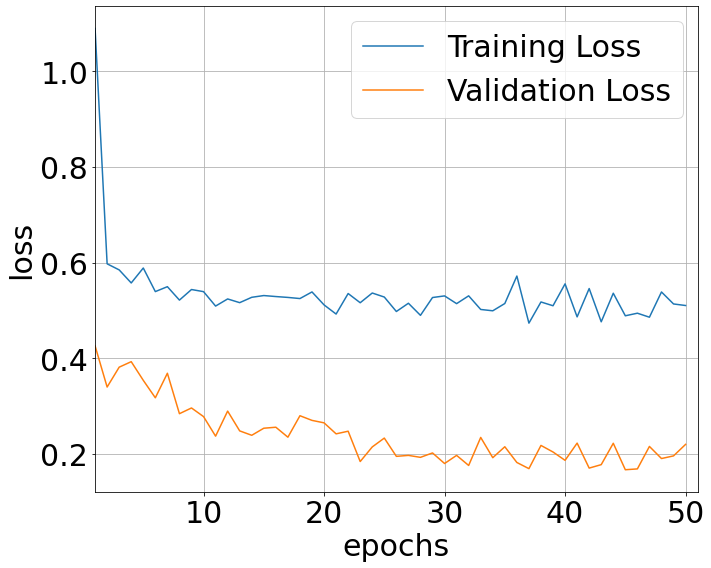

In [28]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
plt.xlabel('epochs',fontsize=30)
plt.ylabel('loss',fontsize=30)

# # find position of lowest validation loss
# minposs = valid_loss.index(min(valid_loss))+1 
# plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

#plt.ylim(0, 0.5) # consistent scale
plt.xlim(1, len(train_loss)+1) # consistent scale
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.grid(True)
plt.legend(loc = 'best',fontsize=30)
plt.tight_layout()
fig.savefig('face_50_loss.png', bbox_inches='tight',dpi=300)
plt.show()

## Accuracy

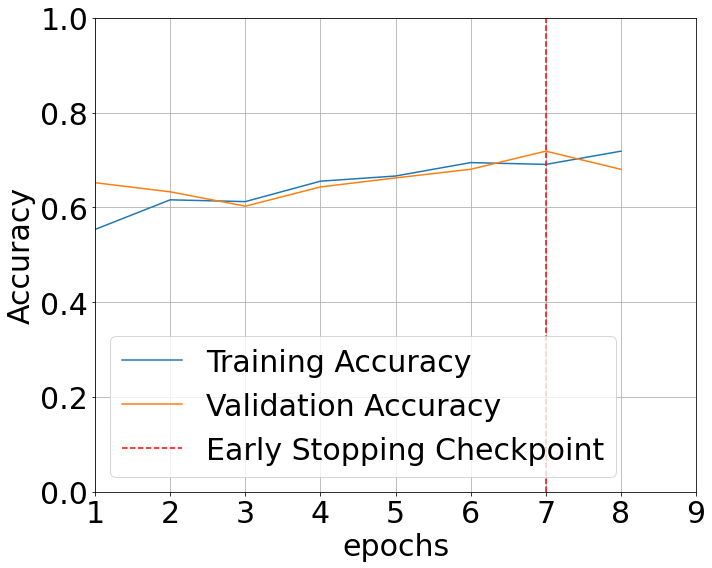

In [22]:
# visualize the accuracy as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
maxposs = valid_acc.index(max(valid_acc))+1 
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs',fontsize=30)
plt.ylabel('Accuracy',fontsize=30)
plt.ylim(0, 1) # consistent scale
plt.xlim(1, len(train_loss)+1) # consistent scale
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.grid(True)
plt.legend(loc = 'best',fontsize=30)
plt.tight_layout()
plt.show()
fig.savefig('Accuracy_plot.png', bbox_inches='tight',dpi=300)